In [1]:
# Import Statements


%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchsample
from torchsample import transforms as ts_transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import importlib


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
color = sns.color_palette()


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_classes=5


#from torchsample.transforms import RangeNorm

import functions.fine_tune as ft

plt.ion()   # interactive mode

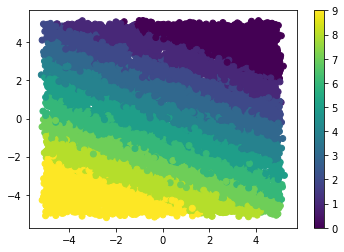

In [2]:
num_classes = 10
dim = 2

def generateLinearData(num_samples = 10000, num_classes = num_classes, dim = dim, bound = 5, sigma_noise = .1,rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    label = np.dot((np.random.rand(1,dim)*bound*2-bound).reshape(1,-1),fvec)

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateLinearData(rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label)
plt.colorbar()


In [ ]:
def generateCircularData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
        
    fvec = np.random.rand(dim, num_samples)*bound*2-bound
    
    fvec_l = np.sum(fvec**2, axis = 0).reshape(1,-1)
    print(fvec_l.shape)
    label = fvec_l

    sorted_idx = np.argsort(label)
    bin_size = label.shape[1]/num_classes

    for k in range(0, num_classes):
        label[0, sorted_idx[0, np.floor(k*bin_size).astype(int):np.floor((k+1)*bin_size).astype(int)]] = rand_classes[k]

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

fvec, label = generateCircularData(num_classes =5, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Greys'))


In [ ]:
def generateSpiralData(num_samples = 10000, num_classes = 9, dim = 2,
                         bound = 1, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]
    sample_per_class = int(num_samples/num_classes)
    num_samples = sample_per_class*num_classes
    fvec = np.zeros((dim, sample_per_class*num_classes))
    label = np.zeros((1, sample_per_class*num_classes))
    
    t = np.linspace(0, 10, sample_per_class)
    x = t * np.cos(t)
    y = t * np.sin(t)
    x = x.reshape(1, -1)
    y = y.reshape(1, -1)

    cons = .7
    for k in range(0, num_classes):
        r = np.linspace(0.05, 1, sample_per_class)
        t = np.linspace(k*cons, (k+6)*cons, sample_per_class)
        x = np.cos(t)
        y = np.sin(t)
        x = x.reshape(1, -1)
        y = y.reshape(1, -1)
        label[0, k*sample_per_class:(k+1)*sample_per_class] = rand_classes[k]
        fvec[0, k*sample_per_class:(k+1)*sample_per_class] = bound * x * r
        fvec[1, k*sample_per_class:(k+1)*sample_per_class] = bound * y * r

    label = label.astype(np.int)
    n = sigma_noise * np.random.randn(dim, num_samples)
    fvec = fvec + n
    
    return fvec.T, label.reshape(label.shape[1])

plt.figure(figsize=(15,7))
X, y = generateSpiralData(num_classes = 9, sigma_noise = 0.01, rand_label = False)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.get_cmap('Set1'))
plt.colorbar()

In [ ]:
def generateSpiralData(num_samples = 10000, num_classes = num_classes, dim = dim,
                         bound = 5, sigma_noise = .1, rand_label = False):
    
    if  rand_label:
        rand_classes = np.random.permutation(num_classes)
    else:
        rand_classes = np.arange(num_classes)
    
    #rand_classes = [1, 1.5, -1, -1.5]

    cons = 4
    N = num_samples # number of points per class
    D = dim # dimensionality
    K = num_classes # number of classes

    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*sigma_noise # theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    
    label = y.astype(np.int)
    fvec = X
    
    return fvec, label

plt.figure(figsize=(15,7))
plt.subplot(121)
fvec, label = generateCircularData(num_classes =9, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
plt.subplot(122)
fvec, label = generateSpiralData(num_classes = 3, sigma_noise = 0, rand_label = False)
plt.scatter(fvec[:, 0], fvec[:, 1], c=label, cmap = plt.get_cmap('Set1'))
plt.colorbar()
#plt.savefig('circular_vs_spiral.tiff')

# Ordinal Regression Benchmark Datasets

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
num_bins=10

In [3]:
from subprocess import check_output
print(check_output(["ls", "./dataset/regression"]).decode("utf8"))

bank32nh.data
bank8FM.data
bostonhousing
cal_housing.data
cpu_act.data
cpu_small.data
house_16H.data
house_8L.data
housing
results.csv
stock
stocksdomain



In [ ]:
train_df = pd.read_csv("./dataset/regression/cpu_act", sep=',', header=None)
train_df=train_df.drop(train_df.columns[-1],axis=1)
print(train_df.shape)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

In [4]:
#train_df = pd.read_csv("./dataset/regression/housing", sep='\s+', header=None)
train_df = pd.read_csv("./dataset/regression/house_16H.data", sep=',', header=None)
#train_df=train_df.drop(train_df.columns[-1],axis=1)

columns=["feat"+str(k) for k in range(train_df.shape[1])]
columns[-1]="label"
train_df.columns=columns

train_df.shape

(22784, 17)

In [115]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,label,label_ord
0,15512.0,0.460869,0.049252,0.226470,0.149827,0.752837,0.010057,0.579729,0.003251,0.075912,0.625318,0.036613,0.991377,0.260116,0.052246,0.774059,130600.0,9.0
1,1550.0,0.470968,0.002581,0.137419,0.096341,0.862581,0.000000,0.695142,0.005025,0.043551,0.064263,0.003350,0.994975,0.285266,0.060606,0.142857,40500.0,6.0
2,4741.0,0.485341,0.000211,0.189412,0.135656,0.856992,0.000000,0.683584,0.004143,0.027965,0.065796,0.000000,0.997411,0.315433,0.065116,0.687500,28700.0,4.0
3,467.0,0.498929,0.000000,0.100642,0.085470,0.907923,0.000000,0.780488,0.006098,0.018293,0.057471,0.000000,1.000000,0.149425,0.139535,1.000000,28500.0,4.0
4,310.0,0.474194,0.680645,0.225806,0.128834,0.896774,0.000000,0.756302,0.008403,0.016807,0.077519,0.672269,0.991597,0.147287,0.000000,0.000000,24100.0,3.0


In [5]:
print(np.arange(10,1,-1))

[10  9  8  7  6  5  4  3  2]


In [6]:
'''
Only for house_16H
'''
label=train_df.label.values
trash_idx = label<=sorted(label)[1000]
for k in np.arange(len(trash_idx)-1,-1,-1):
    if(trash_idx[k]):
        train_df = train_df.drop(train_df.index[k])


In [126]:
label=train_df.label.values
print(np.min(label))

15000.0


Number of Samples per class is 1962.1
[0.0, 19800.000100000001, 24000.000199999999, 27900.0003, 32200.000400000001, 37500.000500000002, 44300.000599999999, 54800.000699999997, 72000.000799999994, 112600.0009, 500001.00099999999]
[0.0, 19800.000100000001, 24000.000199999999, 27900.0003, 32200.000400000001, 37500.000500000002, 44300.000599999999, 54800.000699999997, 72000.000799999994, 112600.0009, 500002.00099999999]
500001.0
Unique labels are [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


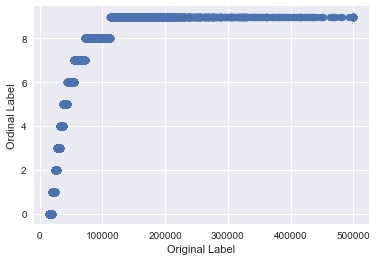

In [7]:

label=train_df.label.values
sorted_idx=np.argsort(train_df.label.values)
num_samples_per_class=train_df.shape[0]/num_bins
print('Number of Samples per class is ' + str(num_samples_per_class))
bins=[(k*1e-4+label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]]) for k in range(1,num_bins+1)]
bins.insert(0,0.0)
print(bins)
bins[-1]=bins[-1]+1
print(bins)

label_ord=label.copy()
k = 10

print(label[sorted_idx[np.round(k*num_samples_per_class-1).astype(np.int)]])
for k in range(num_bins):
    #print(np.all([label>=bins[k], label<bins[k+1]],0))
    label_ord[np.all([label>=bins[k], label<bins[k+1]],0)]=k
    
print('Unique labels are ' + str(np.unique(label_ord)))


train_df['label_ord']=label_ord
#print(train_df.head())

plt.scatter(label,label_ord)
plt.xlabel('Original Label')
plt.ylabel('Ordinal Label')
plt.show()


In [12]:
train_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,label,label_ord
0,15512.0,0.460869,0.049252,0.226470,0.149827,0.752837,0.010057,0.579729,0.003251,0.075912,0.625318,0.036613,0.991377,0.260116,0.052246,0.774059,130600.0,9.0
1,1550.0,0.470968,0.002581,0.137419,0.096341,0.862581,0.000000,0.695142,0.005025,0.043551,0.064263,0.003350,0.994975,0.285266,0.060606,0.142857,40500.0,6.0
2,4741.0,0.485341,0.000211,0.189412,0.135656,0.856992,0.000000,0.683584,0.004143,0.027965,0.065796,0.000000,0.997411,0.315433,0.065116,0.687500,28700.0,4.0
3,467.0,0.498929,0.000000,0.100642,0.085470,0.907923,0.000000,0.780488,0.006098,0.018293,0.057471,0.000000,1.000000,0.149425,0.139535,1.000000,28500.0,4.0
4,310.0,0.474194,0.680645,0.225806,0.128834,0.896774,0.000000,0.756302,0.008403,0.016807,0.077519,0.672269,0.991597,0.147287,0.000000,0.000000,24100.0,3.0


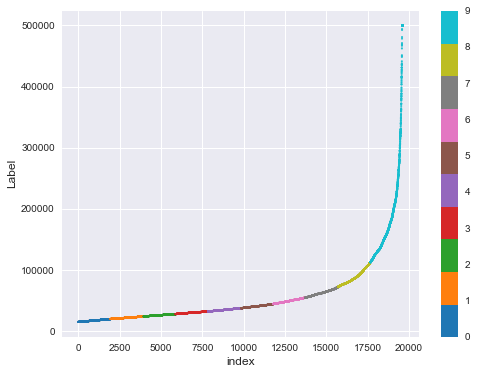

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), label[sorted_idx],s=3,
            c=np.sort(label_ord[sorted_idx]), cmap = plt.get_cmap('tab10'))
plt.colorbar()
plt.xlabel('index', fontsize=12)
plt.ylabel('Label', fontsize=12)

#plt.savefig('cpu_act.png')

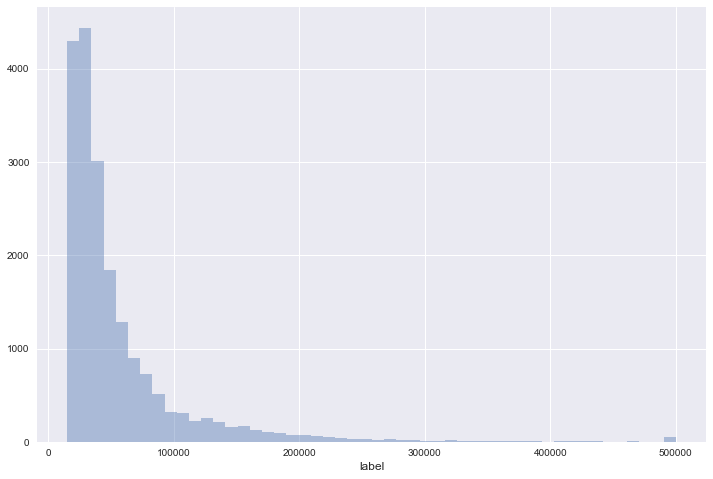

In [9]:
'''ulimit = np.percentile(train_df.label.values, 98)
llimit = np.percentile(train_df.label.values, 2)
train_df['label'].ix[train_df['label']>ulimit] = ulimit
train_df['label'].ix[train_df['label']<llimit] = llimilabel=train_df.label.valuest'''

plt.figure(figsize=(12,8))
sns.distplot(train_df.label.values, bins=50, kde=False)
plt.xlabel('label', fontsize=12)


(array([ 1964.,  1998.,  1934.,  1957.,  1999.,  1937.,  1947.,  1961.,
         1965.,  1959.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

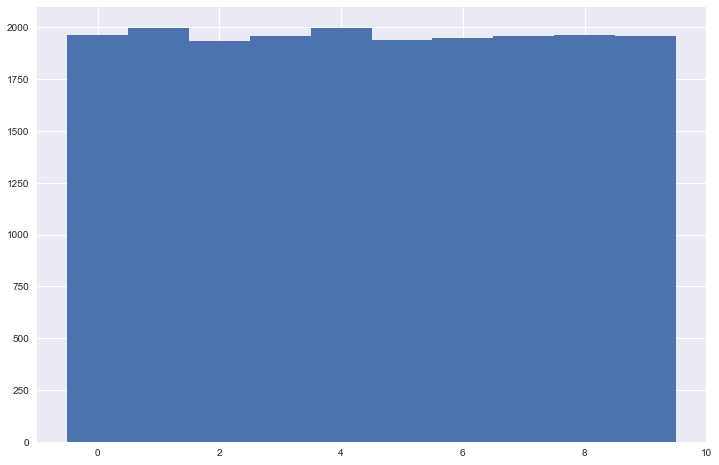

In [10]:
plt.figure(figsize=(12,8))
plt.hist(label_ord, bins = [k-.5 for k in range(11)])

# Train an MLP network

In [8]:
def make_coeff(n, metric, lmbda = 1):
    if metric is 'ccr':
        return [1]
    elif metric is 'ccr1':
        return [lmbda, 1, lmbda]
    elif metric is 'mae':
        coeff = np.arange(1,n)/(n-1)
    elif metric is 'mse':
        coeff = np.zeros(n-1)
        coeff[0] = 2*n-3
        for k in range(1, n-1):
            coeff[k] = coeff[k-1] + 2*n - (2*(k+1)+1)
        coeff = coeff /((n-1)**2)
    else:
        print('Undefined Metric: ' + metric)
    coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    coeff = coeff * lmbda
    coeff[n-2] = 1
    return coeff

In [11]:
def make_coeff(n, metric, loss='softmax', lmbda = 1):
    if metric is 'ccr':
        return np.eye(n)
    elif metric is 'ccr1':
        coeff = np.zeros((n,n))
        for k in range(n):
            coeff[k,np.maximum(k-1,0):np.minimum(k+2,n)]=1
        if loss is 'softmax':
            coeff_sum = np.sum(coeff,axis=1).reshape(-1,1)*np.ones((1,n))
            coeff = coeff/coeff_sum
    elif metric is 'mae':
        coeff = np.zeros((n,n))
        for k in range(n):
            alpha = 1/(n-1)
            row = np.zeros((1,n))
            for l in range(n-1):
                row_ = np.zeros((1,n))
                row_[0, np.maximum(k-l,0):np.minimum(k+l+1,n)] = 1
                if loss is 'softmax':
                    row_ = row_/np.sum(row_)
                row += row_*alpha
            coeff[k,:]=row
    elif metric is 'mse':
        coeff = np.zeros((n,n))
        for k in range(n):
            row = np.zeros((1,n))
            for l in range(n-1):
                row_ = np.zeros((1,n))
                row_[0, np.maximum(k-l,0):np.minimum(k+l+1,n)] = 1
                row += (2*l+1)*row_
                
            if loss is 'softmax':
                row = row / np.sum(row)
            elif loss is 'sigmoid':
                row = row / ((n**2)-(2*n)+1)
            else:
                 print('Undefined Loss: ' + loss)
            coeff[k,:]=row
    else:
        print('Undefined Metric: ' + metric)
        
    coeff = np.eye(n)*(1-lmbda) + lmbda*coeff
        
    #coeff = np.concatenate((coeff, coeff[::-1][1:]), axis=0)
    #coeff = coeff * lmbda
    #coeff[n-2] = 1
    return coeff

coeff = make_coeff(5,'ccr',loss = 'softmax', lmbda=.5)
print(coeff)

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]


In [ ]:
n=4
coeff = np.zeros((n,n))
for k in range(n):
    coeff[k,np.maximum(k-1,0):np.minimum(k+2,n)]=1
coeff[1,2]=5
print(coeff)

coeff_sum = np.max(coeff,axis=1).reshape(-1,1)*np.ones((1,n))

print(coeff/coeff_sum)

In [ ]:
numOut = 5
label = 0

print(make_coeff(numOut,'mae',1))
single_coeff = make_coeff(5,'mae',1)
extend = int((len(single_coeff) - 1) / 2)
label_multi = np.zeros(numOut + 2 * extend)
label_multi[label:label + 2 * extend + 1] = single_coeff
label_multi = label_multi[extend:-extend]
print(label_multi)

In [12]:
data_type = 'house_16H'
num_samples = 10000
num_classes = 9
nclasses = num_classes
dim = 2

sigma_noise = 0.01
optimizer='sgd' #Optimizer function
iter_loc=11 #Number of the first column in the excel file for writing the results.
lr=.5 #Initial learning rate
momentum=0.9
weight_decay=0.0005
batch_size = 256
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=10 #Number of epoch for learning rate decay
hidden_sizes = [50, 50]
dropouts = [0, 0]
rand_label = False

metric = 'ccr'
coeff_lmbda =  1
multi_coeff = make_coeff(nclasses, metric,lmbda = coeff_lmbda)
KL = False #KL divergence for porbability measure


'''Multipliers for loss functions'''
single_loss=1.
multi_loss=0.

comment=' ' #Additional comments if any

algo = None
test = False


In [13]:
CV = 0
random_seed = 1
test_ratio = .2

if data_type == 'circular':
    fvec, label = generateCircularData(num_samples = num_samples, 
                                       num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'linear':
    fvec, label = generateLinearData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
elif data_type == 'spiral':
    fvec, label = generateSpiralData(num_samples = num_samples, 
                                     num_classes = num_classes, dim = dim, bound = 5,
                                       sigma_noise = sigma_noise, rand_label = rand_label)
else:
    num_classes = num_bins
    nclasses = num_classes
    
    feat=train_df.values[:,:-2]
    #Normalize the features

    feat_max = np.amax(feat,axis=0)
    feat_min = np.amin(feat,axis=0)

    feat=(feat-feat_min)/(feat_max-feat_min)
    feat=feat*2-1

    label_ord=train_df.values[:,-1].astype(np.int)
    label_real=train_df.values[:,-2].astype(np.int)
    
    np.random.seed(5)
    rand_idx = np.random.permutation(len(label_ord))
    feat = feat[rand_idx, :]
    label = label_ord[rand_idx]
    label_real = label_real[rand_idx]


    print(np.mean(feat,axis=0))
    print(np.min(feat,axis=0))
    print(feat.shape)
    print(label)

    fvec=feat.copy()
    dim = feat.shape[1]
    
    if not CV == 0: 
        dset_train= torch.utils.data.TensorDataset(torch.from_numpy(fvec).type(torch.FloatTensor),
                                                       torch.from_numpy(label).type(torch.LongTensor))
        dset_val= torch.utils.data.TensorDataset(torch.from_numpy(fvec).type(torch.FloatTensor),
                                                       torch.from_numpy(label).type(torch.LongTensor))


        num_train = len(dset_train)
        indices = list(range(num_train))
        np.random.seed(random_seed)
        np.random.shuffle(indices)

        splits = (num_train*np.linspace(0,1,CV+1)).astype(int)

        val_idx = [indices[splits[k]:splits[k+1]] for k in range(CV)]
        train_idx=[np.setdiff1d(indices,val_idx[k]) for k in range(CV)]
        '''Sampler functions for validation and training'''
        sampler_train = [torch.utils.data.sampler.SubsetRandomSampler(train_idx[k]) for k in range(CV)]
        sampler_val = [torch.utils.data.sampler.SubsetRandomSampler(val_idx[k]) for k in range(CV)]

        '''Define dataset loaders'''
        dset_loaders_arr = [{'train':torch.utils.data.DataLoader(dset_train, batch_size=batch_size,sampler=sampler_train[k],
                                                            num_workers=12),
                        'val':torch.utils.data.DataLoader(dset_val, batch_size=batch_size,sampler=sampler_val[k],
                                                            num_workers=12)} for k in range(CV)]
        dset_sizes={'train':int(len(dset_train)*(1-1/CV)),'val':int(len(dset_train)*(1/CV))}

        print(dset_sizes)
        print('OR')
        print('Number of training images '+str(len(val_idx)))
        print('Number of validation images '+str(len(train_idx)))
    
    else:
        number_test = int(test_ratio*len(label))
        fvec_test = fvec[:number_test,:]
        fvec_train = fvec[number_test:,:]

        label_test = label[:number_test]
        label_train = label[number_test:]
        
        label_real_test = label_real[:number_test]
        label_real_train = label_real[number_test:]

        torch.from_numpy(label_train).type(torch.LongTensor)
        dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                                       torch.from_numpy(label_train).type(torch.LongTensor)),
               'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                                     torch.from_numpy(label_test).type(torch.LongTensor))}

        dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=True,
                                                            num_workers=12),
                        'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                            num_workers=12)}


        dset_sizes={'train':len(dsets['train']),'val':len(dsets['val'])}
        print(dset_sizes)

use_gpu = torch.cuda.is_available()

#print(dset_sizes)

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

'''inputs, classes = next(iter(dset_loaders['train']))
print(inputs.shape)'''


[-0.99754745 -0.20582679 -0.86870144 -0.65718474 -0.54227184  0.66219074
 -0.9485844   0.27061942 -0.94151428 -0.87549529 -0.79200243 -0.88282023
  0.93128031 -0.39877083 -0.79105337 -0.03698122]
[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
(19621, 16)
[0 7 4 ..., 4 7 0]
{'train': 15697, 'val': 3924}
!!!!! NO CUDA GPUS DETECTED


"inputs, classes = next(iter(dset_loaders['train']))\nprint(inputs.shape)"

(array([ 1558.,  1604.,  1534.,  1565.,  1601.,  1558.,  1546.,  1553.,
         1577.,  1601.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

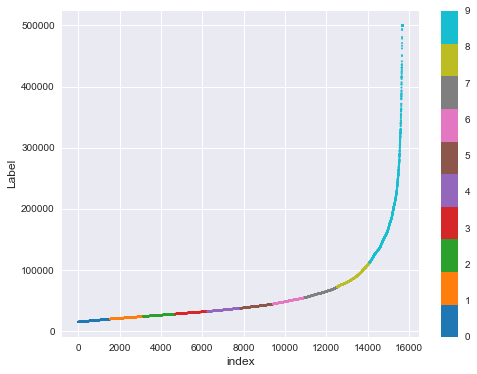

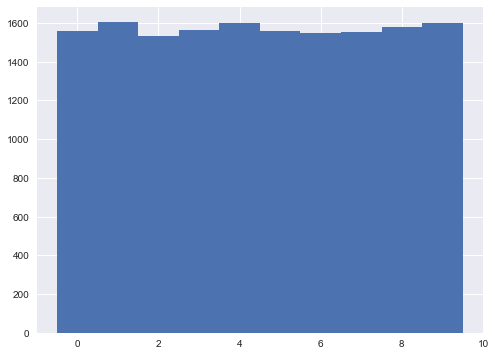

In [14]:
lbel = label_real_train
lbel_ord = label_train
sorted_idx=np.argsort(lbel)

plt.figure(figsize=(8,6))
plt.scatter(range(len(lbel)), lbel[sorted_idx],s=3,
            c=lbel_ord[sorted_idx], cmap = plt.get_cmap('tab10'))
plt.colorbar()
plt.xlabel('index', fontsize=12)
plt.ylabel('Label', fontsize=12)

plt.figure(figsize=(8,6))
plt.hist(lbel_ord, bins=[k-0.5 for k in range(11)])

In [114]:
print(np.sum(label == np.min(label)))

3163


In [ ]:
print(feat.astype(np.float))

In [15]:
def writeLog(logname):
    '''
    Creates a text file named Network_properties.txt inside runs/'logname'
    '''
    f=open('runs_regression/'+logname+'/Network_properties.txt','w')
    f.write('Feature Length: '+str(dim)+'\n')
    f.write('Number of classes: '+str(num_classes)+'\n')
    f.write('Data type: '+data_type+'\n')
    f.write('Random Noise: '+str(sigma_noise)+'\n')
    
    f.write('Hidden sizes: '+ str(hidden_sizes)+'\n')
    f.write('Dropouts: '+str(dropouts)+'\n')
    f.write('Batch size: '+str(batch_size)+'\n')
    f.write('Number of samples: '+str(num_samples)+'\n')
    
    f.write('Optimizer: ' + optimizer + '\n')
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    f.write('Criterion: '+crt+'\n')
    f.write('Learning rate: '+str(lr)+'\n')
    f.write('Momentum: '+str(momentum)+'\n')
    f.write('Leraning Rate Scheduler: '+str(lr_scheduler)+'\n')
    f.write('Leraning Rate Decay Period: '+str(lr_decay_epoch)+'\n')
    f.close()

In [16]:
import openpyxl
import time

def writeLog_xlsx(logname='logs_regression.xlsx',iter_loc=11):
    '''
    Adds a line to logs.xlsx with the network properties and outcomes.
    :param iter_loc: First column to record the outcomes.
    '''
    
    print(logname)
    book = openpyxl.load_workbook(logname)
    sheet = book.active
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    if metric:
        m_coeff = make_coeff(nclasses, metric, coeff_lmbda)
    else:
        m_coeff = multi_coeff
    specs=(datetime.now().strftime('%B%d  %H:%M:%S'),data_type,str(hidden_sizes),str(dim),str(num_classes),
           crt, str(lr), str(metric), str(coeff_lmbda), str(algo))
    sheet.append(specs)
    current_row = sheet.max_row
    sheet.cell(row=current_row, column=iter_loc+5).value = comment
    book.save(logname)
#writeLog_xlsx()

In [17]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropouts, num_classes):
        super(Net, self).__init__()
        self.numHidden=len(hidden_sizes)
        setattr(self, 'fc0', nn.Linear(input_size, hidden_sizes[0]))
        setattr(self, 'relu0', nn.ReLU())
        setattr(self, 'drop0', nn.Dropout(p=dropouts[0]))
        for k in range(len(hidden_sizes)-1):
            setattr(self, 'fc'+str(k+1), nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
            setattr(self, 'relu'+str(k+1), nn.ReLU())
            setattr(self, 'drop'+str(k+1), nn.Dropout(p=dropouts[k+1]))
        setattr(self, 'fc'+str(len(hidden_sizes)), nn.Linear(hidden_sizes[-1], num_classes))
    
    def forward(self, x):
        out=self.fc0(x)
        out = self.relu0(out)
        out = self.drop0(out)
        for k in range(self.numHidden-1):
            fc = getattr(self,'fc'+str(k+1))
            relu = getattr(self,'relu'+str(k+1))
            drop = getattr(self,'drop'+str(k+1))
            out = fc(out)
            out = relu(out)
            out = drop(out)
        fc = getattr(self,'fc'+str(self.numHidden))
        out = fc(out)
        return out
    
model=Net(2, [50, 50], [0, 0], 2)
print(model)

Net(
  (fc0): Linear(in_features=2, out_features=50, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
)


In [18]:
def network_loader(comment=comment,
                    optimizer=optimizer,
                    iter_loc=iter_loc,
                    lr=lr,
                    momentum=momentum,
                    weight_decay=weight_decay,
                    lr_scheduler=lr_scheduler,
                    lr_decay_epoch=lr_decay_epoch,
                    nclasses=num_classes,
                    hidden_sizes = hidden_sizes,
                    dropouts = dropouts):
    
    '''Load the network from pytorch'''
    model_ft = Net(dim, hidden_sizes , dropouts, num_classes)

    if use_gpu:
        model_ft = model_ft.cuda()

    '''Define the optimizer function'''
    if(optimizer=='adam'):
        optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
    elif(optimizer=='sgd'):
        if(end_to_end):
            optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)
    return model_ft, optimizer_ft

In [ ]:
model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
a_vec = Variable(torch.randn(10, 1), requires_grad=True)
params = optimizer_ft.param_groups
params[0]['params'].append(a_vec)
optimizer_ft.param_groups = params
print(optimizer_ft.param_groups)
#optimizer_ft.add_param_group({'params': a_vec})

In [19]:
def write_epochs(result_log, logname):
    print(len(result_log))

    wb_tr = openpyxl.Workbook()
    ws_tr = wb_tr.active
    wb_val = openpyxl.Workbook()
    ws_val = wb_val.active
    print(logname)

    label_arr_tr = np.zeros((100000,1))
    probs_arr_tr = np.zeros((100000, num_classes))
    label_arr_val = np.zeros((100000,1))
    probs_arr_val = np.zeros((100000, num_classes))

    prev_epoch = 0
    
    count_tr = count_val = 0
    for result in result_log:
        epoch = result[1]
        if not epoch == prev_epoch:
            label_arr_tr = label_arr_tr[:count_tr]
            probs_arr_tr = probs_arr_tr[:count_tr, :]
            label_arr_val = label_arr_val[:count_val]
            probs_arr_val = probs_arr_val[:count_val, :]
            ws_tr.append(['Epoch ' + str(prev_epoch)])
            ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
            ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_tr[1:,:].T.tolist():
                ws_tr.append(probs)
            #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
            ws_val.append(['Epoch ' + str(prev_epoch)])
            ws_val.append(label_arr_val[1:].reshape(-1).tolist())
            ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
            for probs in probs_arr_val[1:,:].T.tolist():
                ws_val.append(probs)
    

            label_arr_tr = np.zeros((100000,1))
            probs_arr_tr = np.zeros((100000, num_classes))
            label_arr_val = np.zeros((100000,1))
            probs_arr_val = np.zeros((100000, num_classes)) 
            count_tr = count_val = 0
            prev_epoch = epoch

        label = np.asarray(result[2]).reshape(-1,1)
        scores = np.asarray(result[3])
        exp_scores = np.exp(scores - np.max(scores,axis=1).reshape(-1, 1)*np.ones(num_classes))
        probs = np.round(exp_scores/(np.sum(exp_scores,axis=1).reshape(-1, 1)*np.ones(num_classes)), decimals=2)
        if result[0] == 'train':
            label_arr_tr[count_tr:count_tr + len(label)]  = label
            probs_arr_tr[count_tr:count_tr + len(label), :] = probs
            count_tr += len(label)
        elif result[0] == 'val':
            label_arr_val[count_val:count_val + len(label)]  = label
            probs_arr_val[count_val:count_val + len(label), :] = probs
            count_val += len(label)


    
    label_arr_tr = label_arr_tr[:count_tr]
    probs_arr_tr = probs_arr_tr[:count_tr, :]
    label_arr_val = label_arr_val[:count_val]
    probs_arr_val = probs_arr_val[:count_val, :]
            
    ws_tr.append(['Epoch ' + str(epoch)])
    ws_tr.append(label_arr_tr[1:].reshape(-1).tolist())
    ws_tr.append(np.argmax(probs_arr_tr[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_tr[1:,:].T.tolist():
        ws_tr.append(probs)
    #wb_tr.save('./runs_ord/'+logname + '/train.xlsx')
    ws_val.append(['Epoch ' + str(epoch)])
    ws_val.append(label_arr_val[1:].reshape(-1).tolist())
    ws_val.append(np.argmax(probs_arr_val[1:,:], axis=1).reshape(-1).tolist())
    for probs in probs_arr_val[1:,:].T.tolist():
        ws_val.append(probs)
    wb_val.save('./runs_regression/'+logname + '/val.xlsx')
    label_arr_tr = np.zeros((1,1))
    probs_arr_tr = np.zeros((1, num_classes))
    label_arr_val = np.zeros((1,1))
    probs_arr_val = np.zeros((1, num_classes))
    prev_epoch = epoch
    print('Finito')
    
    del label_arr_tr, probs_arr_tr, label_arr_val, probs_arr_val


In [20]:
importlib.reload(ft)
    
def run_network():
    '''
    Cretaes the log files and starts the training
    '''
    model_ft, optimizer_ft = network_loader(comment=comment, #'Tested for three rooms'
                                            optimizer=optimizer,
                                            iter_loc=iter_loc,
                                            lr=lr,
                                            momentum=momentum,
                                            weight_decay=weight_decay,
                                            lr_scheduler=lr_scheduler,
                                            lr_decay_epoch=lr_decay_epoch,
                                            nclasses=num_classes)
    
    
    '''Name of the trial'''
    crt=str(single_loss)+'xsingle + '+str(multi_loss)+'Xmulti'
    logname='Ordinal_'+datetime.now().strftime('%B%d  %H:%M:%S')
    writer = SummaryWriter('runs_regression/'+logname) #For tensorboard
    writeLog(logname)
    writeLog_xlsx()
    
    '''Start trianing'''
    if metric:
        m_coeff = make_coeff(nclasses, metric, loss='sigmoid', lmbda=coeff_lmbda)
        s_coeff = make_coeff(nclasses, metric, loss='softmax', lmbda=coeff_lmbda)
    else:
        m_coeff = multi_coeff
        s_coeff = multi_coeff
    best_model, last_model, result_log = ft.train_model(model_ft,optimizer_ft, lr_scheduler,dset_loaders,
                            dset_sizes,writer,use_gpu=use_gpu,num_epochs=100,batch_size=batch_size,num_log=250,
                            lr_decay_epoch=lr_decay_epoch,init_lr=lr,regression=False,
                            iter_loc=iter_loc,cross_loss=single_loss,multi_loss=multi_loss,numOut=num_classes,
                            logname='logs_regression.xlsx',
                            multi_coeff = m_coeff, single_coeff = s_coeff, KL = KL, algo = algo, test = test)
    
    '''Save the models'''
    torch.save(best_model,'./saved_models/ord/'+logname+'_best')
    torch.save(last_model,'./saved_models/ord/'+logname+'_last')
    
    '''print('Writing results')
    write_epochs(result_log, logname)
    print('Wrote results')'''
    '''Free up the memory'''
    del model_ft, result_log
    
    writer.close
    del writer
    return last_model


In [ ]:
'''hidden_sizes = [50, 50]
dropouts = [0, 0]
end_to_end = True
run_network()'''
print(fvec.shape)

In [185]:
end_to_end = True
optimizer='sgd' #Optimizer function
lr=1 #Initial learning rate
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler #Learning rate scheduler
lr_decay_epoch=40 #Number of epoch for learning rate decay

hidden_sizes = [64, 64, 128, 128, 256, 512, 256, 128, 64, 32, 16]#8, 16, 8, 4, 4]
dropouts = [0, 0, .5, .5, .5, .5, .5, .5, .5, 0, 0]#.5, .5, .5]

        
single_loss=0.
multi_loss =1.
coeff_lmbda = 1.

metric = 'ccr'
algo = 'weighted_softmax'
KL = True

for lr_now in [1,2,5,10]:
    lr = lr_now
    run_network()



    

logs_regression.xlsx
LR is set to 1.0
LR is set to 0.1
LR is set to 0.010000000000000002
Training complete in 2m 18s
Best val RMSE: 1.763184
logs_regression.xlsx
LR is set to 2.0


/home/mtezcan/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


LR is set to 0.2
LR is set to 0.020000000000000004
Training complete in 2m 20s
Best val RMSE: 1.745681
logs_regression.xlsx
LR is set to 5.0
LR is set to 0.5
LR is set to 0.05000000000000001
Training complete in 2m 23s
Best val RMSE: 2.891206
logs_regression.xlsx
LR is set to 10.0
LR is set to 1.0
LR is set to 0.10000000000000002
Training complete in 2m 22s
Best val RMSE: 2.892220


# Analysis (for CV=0)

Create dataloader again, this time without shuffling

In [21]:
fvec_test = fvec[:number_test,:]
fvec_train = fvec[number_test:,:]

label_test = label[:number_test]
label_train = label[number_test:]

label_real_test = label_real[:number_test]
label_real_train = label_real[number_test:]


dsets={'train': torch.utils.data.TensorDataset(torch.from_numpy(fvec_train).type(torch.FloatTensor),
                                               torch.from_numpy(label_train).type(torch.LongTensor)),
       'val': torch.utils.data.TensorDataset(torch.from_numpy(fvec_test).type(torch.FloatTensor),
                                             torch.from_numpy(label_test).type(torch.LongTensor))}

'''Define dataset loaders'''
dset_loaders = {'train':torch.utils.data.DataLoader(dsets['train'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12),
                'val':torch.utils.data.DataLoader(dsets['val'], batch_size=batch_size,shuffle=False,
                                                    num_workers=12)}

In [22]:
torch.load('./saved_models/ord/Ordinal_April01  17:20:53_last', map_location={'cuda:0': 'cpu'})


/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

Net(
  (fc0): Linear(in_features=16, out_features=50, bias=True)
  (relu0): ReLU()
  (drop0): Dropout(p=0)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [25]:
def validate(model_dir, phase='train'):
    if use_gpu:
        model = torch.load(model_dir)
    else:
        model = torch.load(model_dir, map_location={'cuda:0': 'cpu'})
    model.train(False)

    labels_arr = np.asarray([]);
    preds_arr = np.asarray([]);
    probs_arr = np.zeros((1,num_classes))
    for data in dset_loaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            probs = model(inputs).cpu().data.numpy()
            outputs = np.argmax(model(inputs).cpu().data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.cpu().data.numpy())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
            probs = model(inputs).data.numpy()
            outputs = np.argmax(model(inputs).data.numpy(), axis=1)
            #labels_arr = np.append(labels_arr,labels.data.numpy())
          
        preds_arr = np.append(preds_arr, outputs)
        probs_arr = np.append(probs_arr, probs, axis=0)
    return preds_arr, probs_arr[1:,:]

(pred_test, score_test) = validate('./saved_models/ord/Ordinal_April01  17:20:53_last', phase='val')
(pred_test_ccr, score_test_ccr) = validate('./saved_models/ord/Ordinal_April01  17:31:40_last', phase='val')

print('MAE performance with MAE-based loss is ' + str(np.mean(np.abs(pred_test-label_test))))
print('MAE performance with CCR-based loss is ' + str(np.mean(np.abs(pred_test_ccr-label_test))))

print('CCR performance with MAE-based loss is ' + str(np.mean(pred_test==label_test)))
print('CCR performance with CCR-based loss is ' + str(np.mean(pred_test_ccr==label_test)))

/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original

MAE performance with MAE-based loss is 1.28440366972
MAE performance with CCR-based loss is 1.37640163099
CCR performance with MAE-based loss is 0.287716615698
CCR performance with CCR-based loss is 0.305300713558


In [26]:
prob_test = np.exp(score_test)
prob_test = prob_test / np.sum(prob_test,axis=1).reshape(-1,1)

prob_test_ccr = np.exp(score_test_ccr)
prob_test_ccr = prob_test_ccr / np.sum(prob_test_ccr,axis=1).reshape(-1,1)

'''print(np.sum(prob_test, axis=1))
print(pred_test[:10])
print(prob_test[:10,:])'''

'print(np.sum(prob_test, axis=1))\nprint(pred_test[:10])\nprint(prob_test[:10,:])'

In [27]:
prob_aligned = np.zeros((prob_test.shape[0], 2*num_classes-1))
prob_aligned_ccr = np.zeros((prob_test.shape[0], 2*num_classes-1))


for k in range(prob_test.shape[0]):
    prob_aligned[k, int(num_classes-pred_test[k]-1):int(2*num_classes-pred_test[k]-1)] = prob_test[k,:]
    prob_aligned_ccr[k, int(num_classes-pred_test_ccr[k]-1):int(2*num_classes-pred_test_ccr[k]-1)] = prob_test_ccr[k,:]
    
print(np.argmax(prob_aligned, axis=1))
print(prob_aligned)

[9 9 9 ..., 9 9 9]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   1.40347149e-05
    3.72932928e-07   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.72324656e-03 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   4.04111567e-04
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


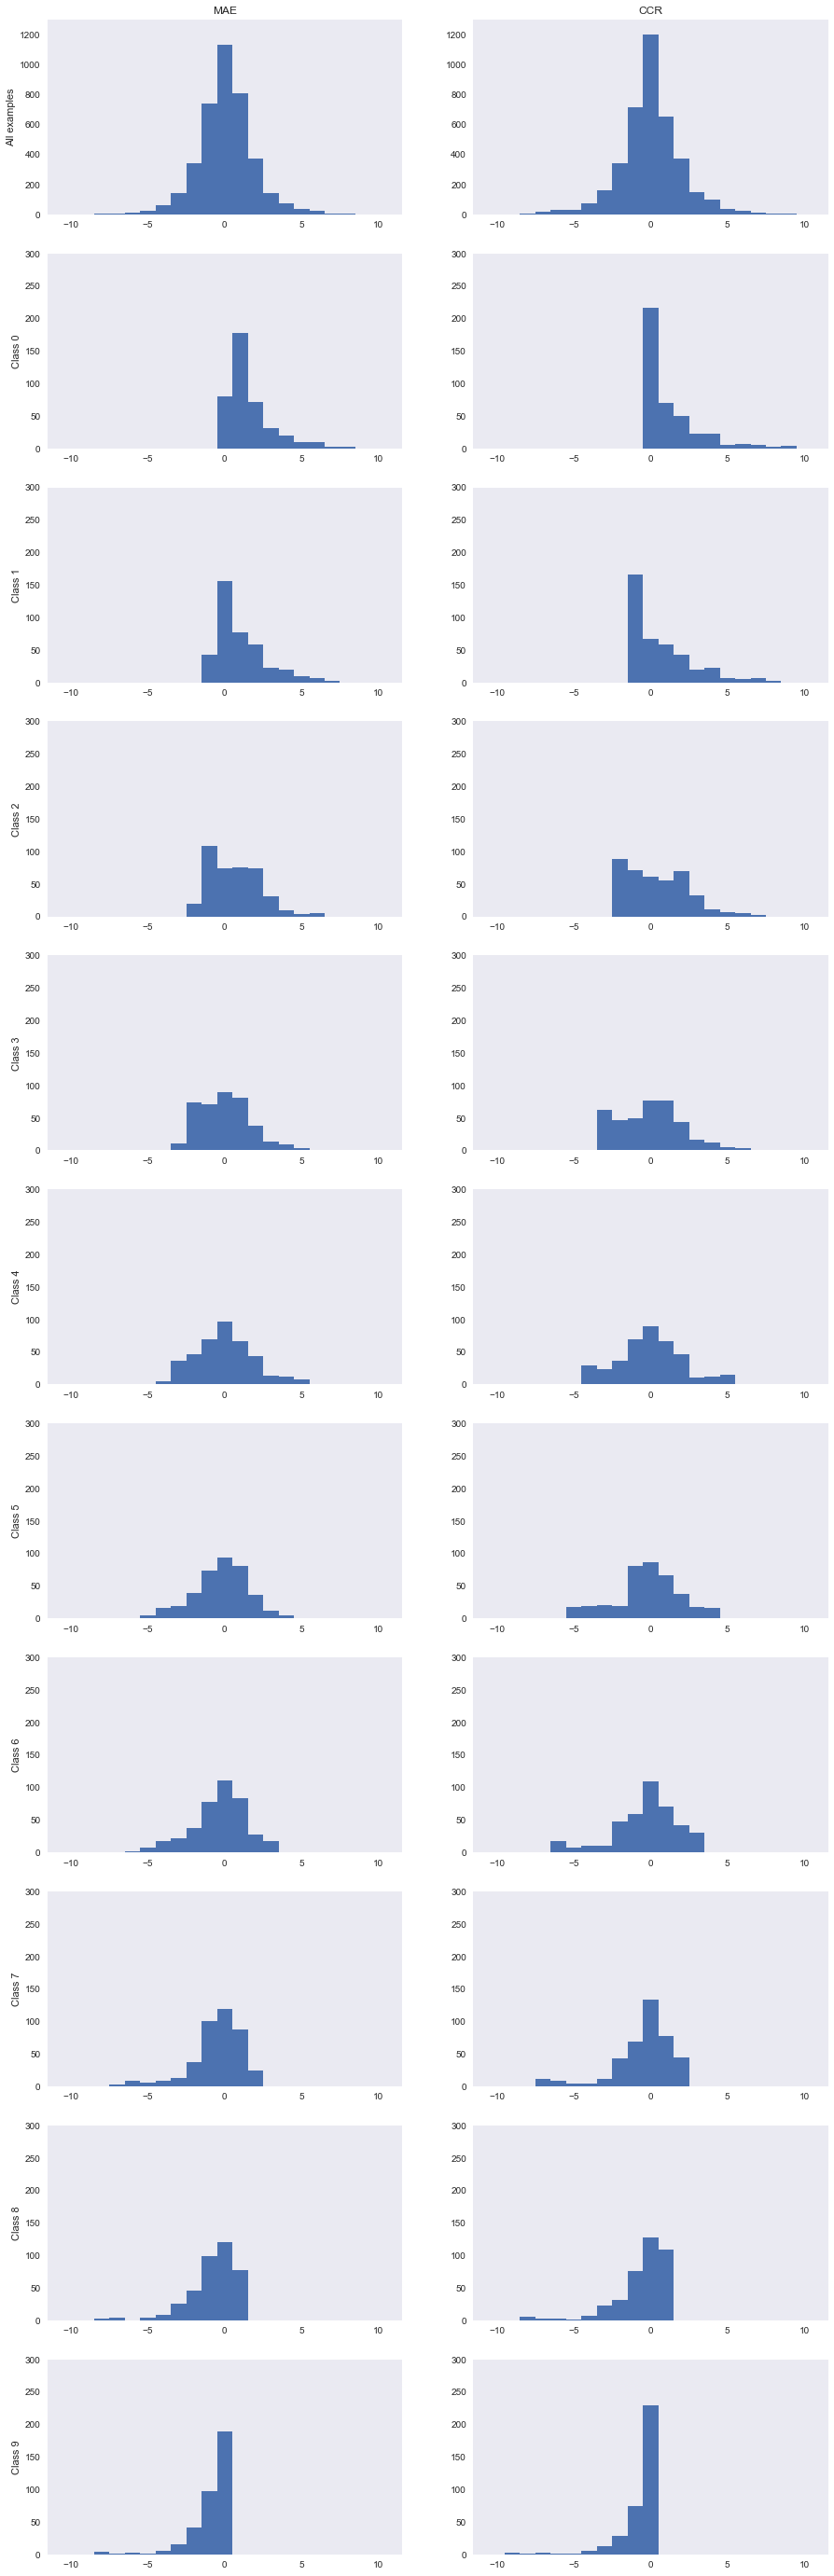

In [140]:
test_err = pred_test - label_test
fig= plt.figure(figsize=(15,50))
plt.subplot(11,2,1)
plt.hist(test_err, bins=[k-0.5 for k in range(-10,12)])
plt.ylim([0,1300])
plt.title('MAE-based loss')
plt.ylabel('All examples')
plt.grid()

for k in range(10):
    plt.subplot(11,2,(2*k+3))
    plt.hist(test_err[label_test==k], bins=[k-0.5 for k in range(-10,12)])
    plt.ylim([0,300])
    plt.grid()
    plt.ylabel('Class ' + str(k))
    
    
test_err = pred_test_ccr - label_test
plt.subplot(11,2,2)
plt.hist(test_err, bins=[k-0.5 for k in range(-10,12)])
plt.ylim([0,1300])
plt.title('CCR-based loss')
plt.grid()

for k in range(10):
    plt.subplot(11,2,(2*k+4))
    plt.hist(test_err[label_test==k], bins=[k-0.5 for k in range(-10,12)])
    plt.ylim([0,300])
    plt.grid()


[[ 80 178  72  31  20   9  10   3   3   0]
 [ 42 156  77  59  23  19   9   6   3   0]
 [ 20 108  74  75  74  31   9   4   5   0]
 [ 11  74  71  90  81  38  13   9   4   1]
 [  5  36  47  69  97  67  43  14  12   8]
 [  5  16  19  39  73  94  81  36  12   4]
 [  1   8  17  21  38  78 110  83  28  17]
 [  3   9   6   9  13  38 100 119  87  24]
 [  3   4   0   4   9  26  46  99 120  77]
 [  0   4   1   2   1   6  16  42  97 189]]
[[216  70  50  23  23   5   7   5   3   4]
 [166  67  59  42  19  22   6   5   6   2]
 [ 88  71  61  55  69  32  11   6   5   2]
 [ 62  46  50  77  76  43  17  12   5   4]
 [ 29  24  36  69  90  66  47  10  12  15]
 [ 17  19  20  19  80  86  67  37  18  16]
 [ 17   7  10  10  47  59 109  70  42  30]
 [ 11   9   4   4  12  43  69 134  77  45]
 [  5   3   3   2   7  23  32  76 128 109]
 [  2   1   2   1   1   5  12  29  75 230]]


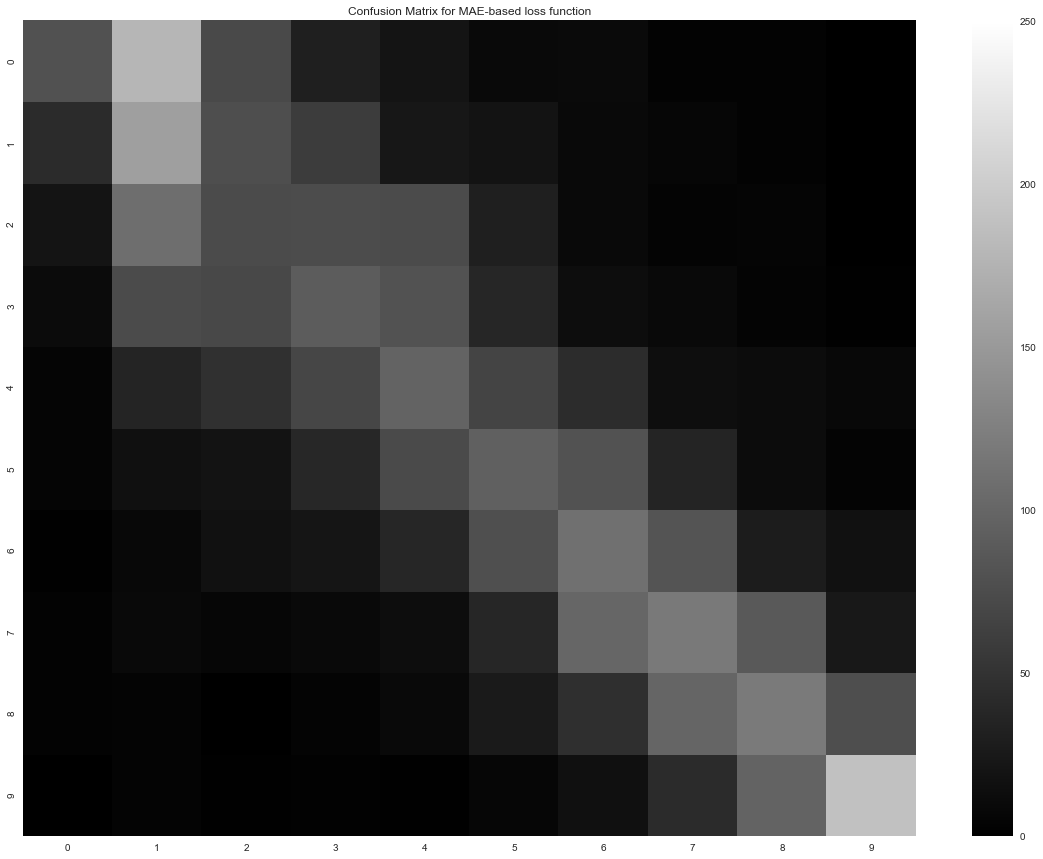

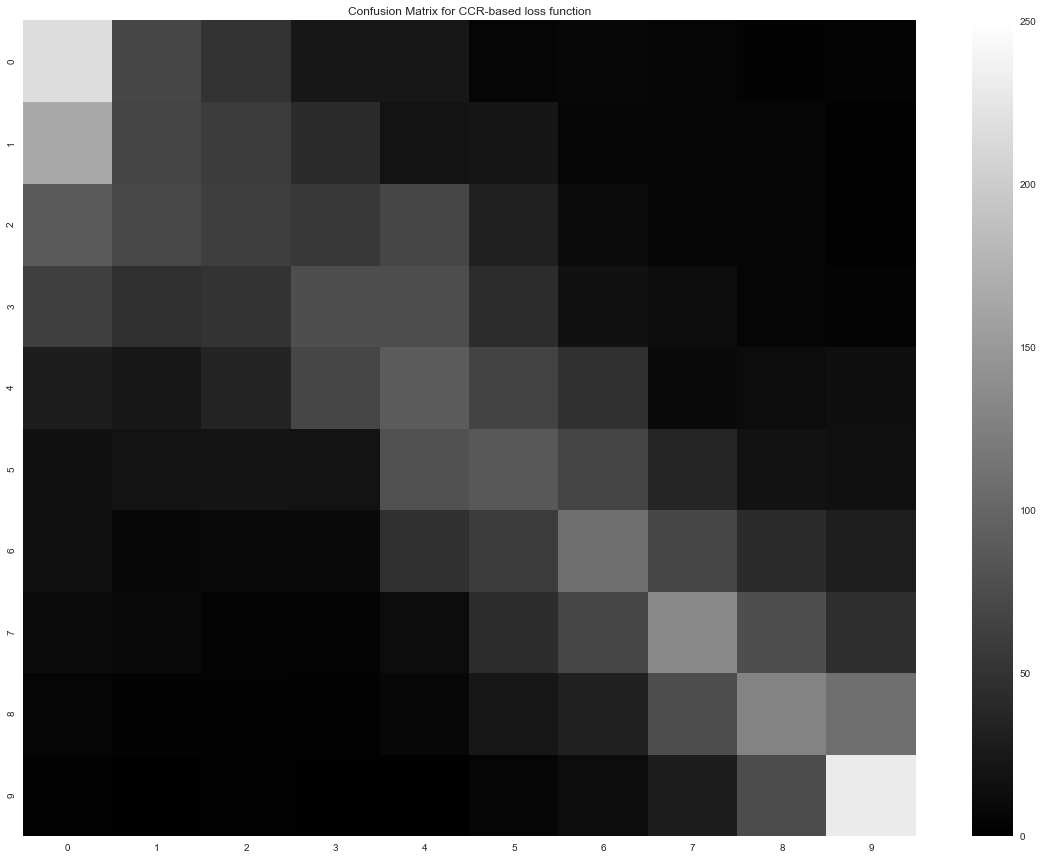

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

c_mat = confusion_matrix(label_test, pred_test)
print(c_mat)

c_mat_ccr = confusion_matrix(label_test, pred_test_ccr)
print(c_mat_ccr)

row_sums = c_mat.sum(axis=1)
#c_mat = c_mat/row_sums[:,np.newaxis]

fig= plt.figure(figsize=(20,15))
#plt.subplot(121)
#plt.imshow(c_mat, cmap='gray', interpolation='nearest')
#plt.colorbar()
sns.heatmap(c_mat, cmap='gray', vmin = 0, vmax = 250)
plt.title('Confusion Matrix for MAE-based loss function')

fig= plt.figure(figsize=(20,15))
#plt.subplot(122)
sns.heatmap(c_mat_ccr, cmap='gray', vmin = 0, vmax = 250)
plt.title('Confusion Matrix for CCR-based loss function')


/Users/ozan-macbook-air/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(0, 0.45)

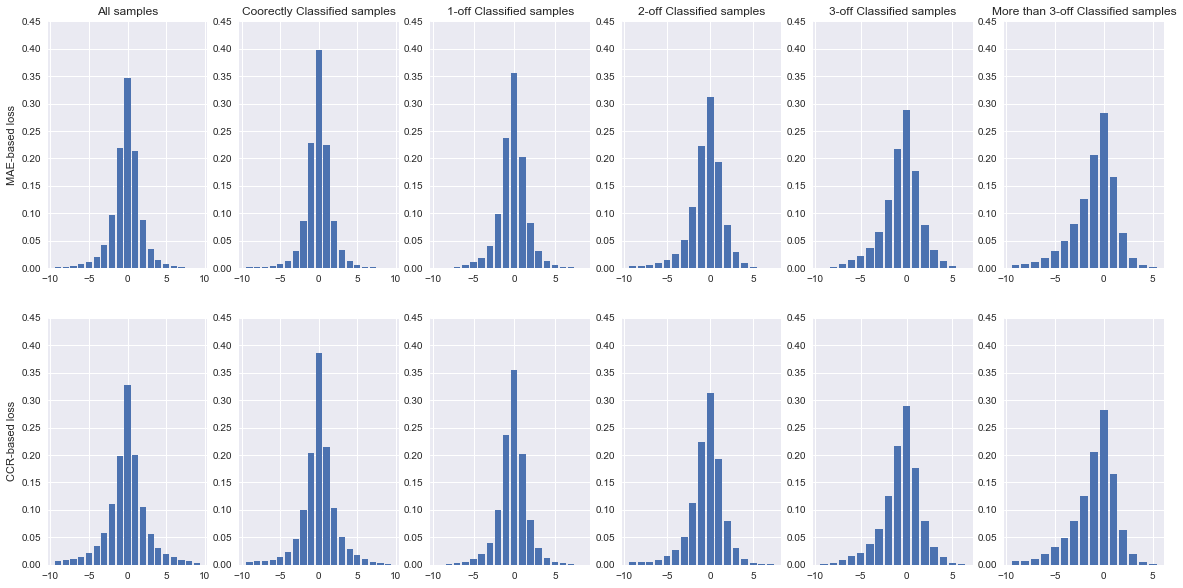

In [42]:
def mean_of_probs(probs):
    prob_mean = np.sum(probs, axis=0) / (np.sum(1-(probs==0).astype(np.int),axis=0))
    return prob_mean

fig= plt.figure(figsize=(20,10))
prob_mean = mean_of_probs(prob_aligned)
plt.subplot(261)
plt.bar(np.arange(-9,10),prob_mean)
plt.ylim([0,0.45])
plt.ylabel('MAE-based loss')
plt.title('All samples')
plt.subplot(262)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[pred_test==label_test,:]))
plt.ylim([0,0.45])
plt.title('Coorectly Classified samples')
plt.subplot(263)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==1,:]))
plt.ylim([0,0.45])
plt.title('1-off Classified samples')
plt.subplot(264)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==2,:]))
plt.ylim([0,0.45])
plt.title('2-off Classified samples')
plt.subplot(265)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==3,:]))
plt.ylim([0,0.45])
plt.title('3-off Classified samples')
plt.subplot(266)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)>3,:]))
plt.ylim([0,0.45])
plt.title('More than 3-off Classified samples')

prob_mean = mean_of_probs(prob_aligned_ccr)
plt.subplot(267)
plt.bar(np.arange(-9,10),prob_mean)
plt.ylim([0,0.45])
plt.ylabel('CCR-based loss')
plt.subplot(268)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned_ccr[pred_test_ccr==label_test,:]))
plt.ylim([0,0.45])
plt.subplot(269)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==1,:]))
plt.ylim([0,0.45])
plt.subplot(2,6,10)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==2,:]))
plt.ylim([0,0.45])
plt.subplot(2,6,11)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)==3,:]))
plt.ylim([0,0.45])
plt.subplot(2,6,12)
plt.bar(np.arange(-9,10),mean_of_probs(prob_aligned[(pred_test-label_test)>3,:]))
plt.ylim([0,0.45])


[[  15000.]
 [  19850.]
 [  24050.]
 [  27950.]
 [  32250.]
 [  37550.]
 [  44350.]
 [  54850.]
 [  72050.]
 [ 112650.]
 [ 500001.]]
[[  17425. ]
 [  21950. ]
 [  26000. ]
 [  30100. ]
 [  34900. ]
 [  40950. ]
 [  49600. ]
 [  63450. ]
 [  92350. ]
 [ 306325.5]]
[ 22500  21600 132100 ...,  34600  67300  16200]


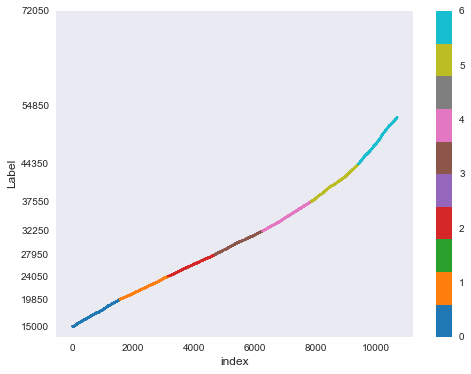

In [43]:
fvec_test = fvec[:number_test,:]
fvec_train = fvec[number_test:,:]

label_test = label[:number_test]
label_train = label[number_test:]

label_real_test = label_real[:number_test]
label_real_train = label_real[number_test:]

thresholds = np.zeros((num_bins+1,1))
thresholds[0] = np.min(label_real_train)
thresholds[-1] = np.max(label_real_train)

for k in range(num_bins-1):
    thresholds[k+1] = (np.max(label_real_train[label_train==k]) + np.min(label_real_train[label_train==k+1]))/2
print(thresholds)

label_means = (thresholds[:-1]+thresholds[1:])/2
print(label_means)
lbel = label_real_train
lbel_ord = label_train
sorted_idx=np.argsort(lbel)

fig= plt.figure(figsize=(8,6))
plt.scatter(range(len(lbel)-5000), lbel[sorted_idx[:-5000]],s=3,
            c=lbel_ord[sorted_idx[:-5000]], cmap = plt.get_cmap('tab10'))

plt.yticks(thresholds[:-2])
plt.grid()
plt.colorbar()
plt.xlabel('index', fontsize=12)
plt.ylabel('Label', fontsize=12)

'''plt.figure(figsize=(8,6))
plt.hist(lbel_ord, bins=[k-0.5 for k in range(11)])'''

print(label_real_train)

In [44]:
temp_min = np.min(thresholds)
temp_range = np.max(thresholds) - np.min(thresholds)
thresholds = (thresholds - temp_min)/temp_range
label_means = (label_means - temp_min)/temp_range
print(thresholds)
print(label_means)
label_real_train = (label_real_train - temp_min)/temp_range
label_real_test = (label_real_test - temp_min)/temp_range

[[ 0.        ]
 [ 0.00999998]
 [ 0.01865976]
 [ 0.02670098]
 [ 0.03556694]
 [ 0.04649475]
 [ 0.06051534]
 [ 0.08216478]
 [ 0.11762862]
 [ 0.20133979]
 [ 1.        ]]
[[ 0.00499999]
 [ 0.01432987]
 [ 0.02268037]
 [ 0.03113396]
 [ 0.04103084]
 [ 0.05350504]
 [ 0.07134006]
 [ 0.0998967 ]
 [ 0.15948421]
 [ 0.6006699 ]]


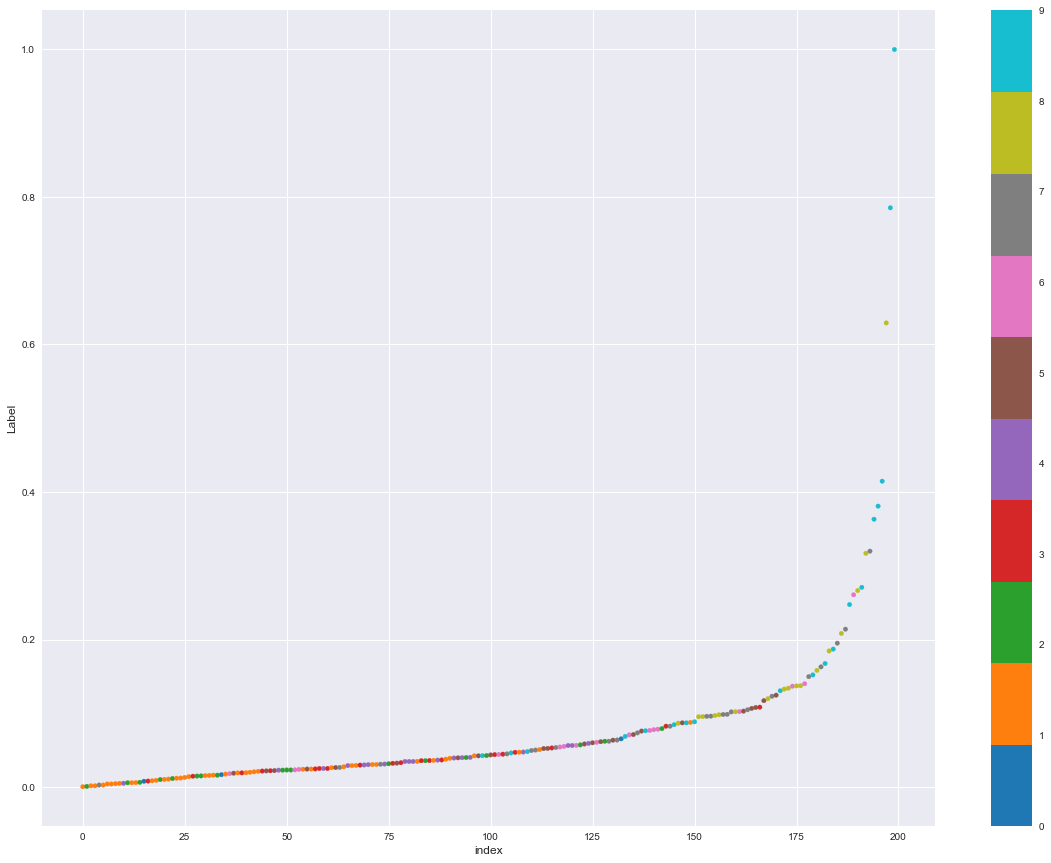

In [45]:
lbel = label_real_test[:200]
lbel_ord = pred_test[:200]
sorted_idx=np.argsort(lbel[:200])
fig= plt.figure(figsize=(20,15))

plt.scatter(range(len(lbel)), lbel[sorted_idx],s=20,
            c=lbel_ord[sorted_idx], cmap = plt.get_cmap('tab10'))

#plt.yticks(label_real_means)
#plt.grid()
plt.colorbar()
plt.xlabel('index', fontsize=12)
plt.ylabel('Label', fontsize=12)
#print(label_real_means)

In [51]:
pred_real_test = pred_test.copy()
for k in range(len(pred_real_test)):
    '''print(pred_test[k])
    print(label_real_means[pred_test[k]])'''
    pred_real_test[k] = label_means[int(pred_test[k])]
print(np.mean(np.abs(pred_real_test-label_real_test)))
print(np.mean(np.abs(pred_test/(num_bins-1)-label_test/(num_bins-1))))

0.0567555790909
0.136482047797


[ 1.  7.  5. ...,  6.  2.  6.]


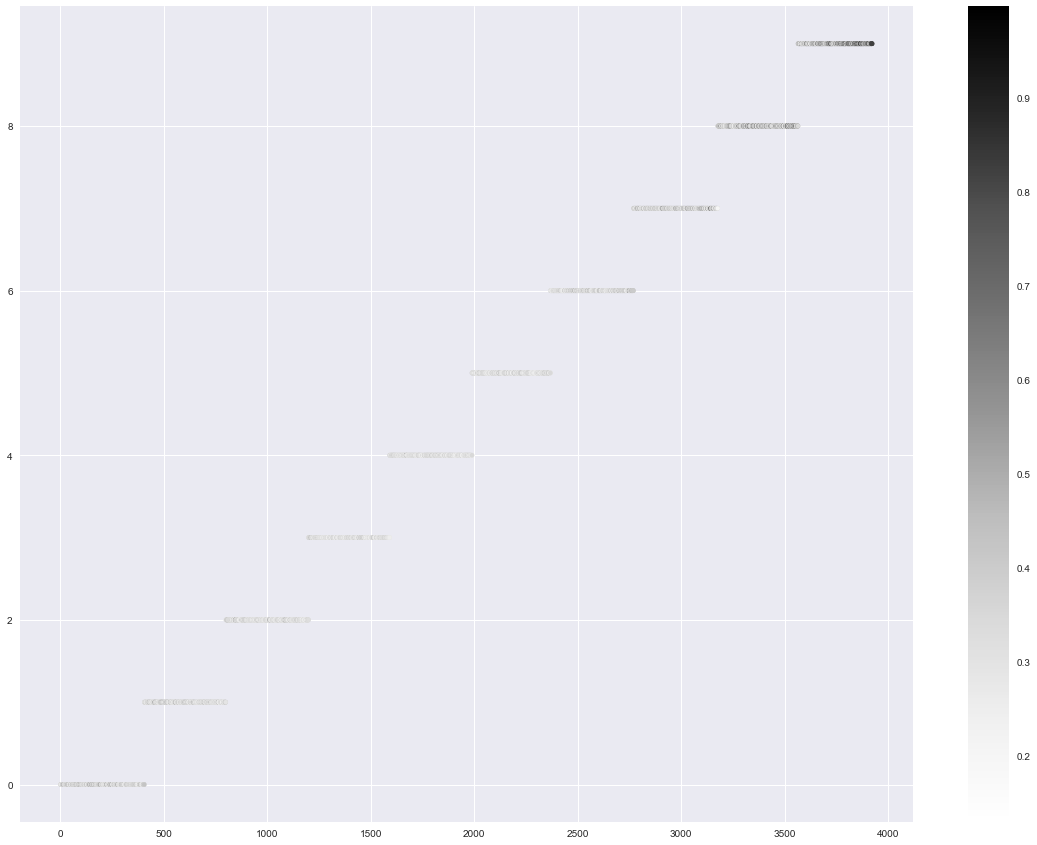

In [142]:
#label_test = label_test[np.argsort(label_real_test)]
#pred_test = pred_test[np.argsort(label_real_test)]
#err_test = (pred_test==label_test).astype(np.int)
#err_test = np.abs(pred_test-label_test)

err_test = prob_aligned[:,9]#/np.max(prob_aligned[:, [8,10]],axis=1)
#err_test[err_test>=2] = 2
print(pred_test)


fig= plt.figure(figsize=(20,15))
#plt.scatter(label_real_test[np.argsort(label_real_test)], pred_test[np.argsort(label_real_test)],s=20,
#            c=label_test[np.argsort(label_real_test)], cmap = plt.get_cmap('tab10'))

plt.scatter(range(len(label_real_test)), label_test[np.argsort(label_real_test)],s=20,
            c=err_test[np.argsort(label_real_test)], cmap = plt.get_cmap('Greys'))
plt.colorbar()

In [47]:
prob_cons = [k for k in range(10)]

#print(prob_cons)
#prob_cons = prob_cons/np.sum(prob_cons,axis=1)
#print(np.round(prob_cons,3))

prob_updated = prob_test @ prob_cons

#print(np.round(prob_cons,3))
pred_updated = np.round(prob_updated).astype(np.int)
print('Lets consider the NINT of expectation as a predition instead of argmax')
print('For MAE-based loss function:')
print('MAE by expectation is ' + str(np.mean(np.abs(pred_updated-label_test))))
print('MAE by argmax is ' + str(np.mean(np.abs(pred_test-label_test))))
print('CCR by expectation is ' + str(np.mean(pred_updated==label_test)))
print('CCR by argmax is ' + str(np.mean(pred_test==label_test)))
#print(np.sum(prob_test,axis=1))

prob_updated_ccr = prob_test_ccr @ prob_cons

print()
#print(np.round(prob_cons,3))
pred_updated_ccr = np.round(prob_updated_ccr).astype(np.int)
print('For CCR-based loss function:')
print('MAE by expectation is ' + str(np.mean(np.abs(prob_updated_ccr-label_test))))
print('MAE by argmax is ' + str(np.mean(np.abs(pred_test_ccr-label_test))))
print('CCR by expectation is ' + str(np.mean(prob_updated_ccr==label_test)))
print('CCR by argmax is ' + str(np.mean(pred_test_ccr==label_test)))

c_mat = confusion_matrix(label_test, pred_updated)
#print(c_mat)

Lets consider the NINT of expectation as a predition instead of argmax
For MAE-based loss function:
MAE by expectation is 1.25968399592
MAE by argmax is 1.28440366972
CCR by expectation is 0.2624872579
CCR by argmax is 0.287716615698
For CCR-based loss function:
MAE by expectation is 1.28190087027
MAE by argmax is 1.37640163099
CCR by expectation is 0.0
CCR by argmax is 0.305300713558


In [46]:
prob_cons = np.zeros((10,10))

for k in range(10):
    for l in range(10):
        prob_cons[k,l] = 9-np.abs(k-l)

#print(prob_cons)
#prob_cons = prob_cons/np.sum(prob_cons,axis=1)
#print(np.round(prob_cons,3))

prob_updated = prob_test @ prob_cons

#print(np.round(prob_cons,3))
pred_updated = np.argmax(prob_updated, axis=1)
print(np.mean(np.abs(pred_updated-label_test)))
print(np.mean(np.abs(pred_test-label_test)))
print(np.mean(pred_updated==label_test))
print(np.mean(pred_test==label_test))
#print(np.sum(prob_test,axis=1))

c_mat = confusion_matrix(label_test, pred_updated)
#print(c_mat)

1.24694189602
1.28440366972
0.278032619776
0.287716615698


## Obsolete (Synthetic Data)

In [ ]:
def validate_and_mean(root_dir, sub_dirs, phase='train'):
    scores_arr = np.zeros((label_train.shape[0],9))
    for sub_dir in sub_dirs:
        if use_gpu:
            model = torch.load(root_dir + '/' + sub_dir)
        else:
            model = torch.load(root_dir + '/' + sub_dir, map_location={'cuda:0': 'cpu'})
        model.train(False)
        #print(model)
        score_arr = np.zeros((1,9))
        for data in dset_loaders[phase]:
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                outputs = model(inputs).cpu().data.numpy()
                #print(outputs.shape)
            else:
                inputs, labels = Variable(inputs), Variable(labels)
                outputs = model(inputs).data.numpy()
                
            score_arr = np.append(score_arr, outputs, axis=0)
        scores_arr += score_arr[1:,:]
        
    return scores_arr
#scores_tr = validate_and_mean('./saved_models/test_circular', last_dirs[:10])
#pred_tr = np.argmax(scores_tr, axis=1)
#print(np.mean(label_train == pred_tr))

In [ ]:
model_dirs = ['./saved_models/ord/Ordinal_January24  10:16:00_last',
             './saved_models/ord/Ordinal_January24  10:20:35_last',
             './saved_models/ord/Ordinal_January24  10:24:20_last',
             './saved_models/ord/Ordinal_January24  10:28:03_last']

'''model_dirs = ['./saved_models/ord/Ordinal_January24  13:09:17_last',
             './saved_models/ord/Ordinal_January24  13:18:08_last',
             './saved_models/ord/Ordinal_January24  13:27:43_last',
             './saved_models/ord/Ordinal_January24  13:43:43_last']'''

model_dirs = ['./saved_models/ord/Ordinal_January26  00:22:14_last',
              './saved_models/ord/Ordinal_January26  00:19:20_last',
              './saved_models/ord/Ordinal_January26  00:09:08_last',
              './saved_models/ord/Ordinal_January26  00:17:53_last']
preds = []

for model_dir in model_dirs:
    preds.append(validate(model_dir))
    
print(len(preds))

In [ ]:
metric = 'CCR1'

if metric is 'CCR1':
    metric_code = 0
elif metric is 'MAE':
    metric_code = 1
else:
    print('Wrong metric')
    
plt.figure(figsize=(20,15))

plt.subplot(4,3,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

metrics = np.zeros((11, 4))
for k in range(10):
    scores_tr = validate_and_mean(data_dir, all_dirs[metric_code][k*10:(k+1)*10])
    pred_tr = np.argmax(scores_tr, axis=1)
    plt.subplot(4,3,k+2)
    plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
    plt.colorbar()
    ccr = np.mean(pred_tr==label_train)
    ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
    mae = np.mean(np.abs(pred_tr-label_train))
    rmse = np.mean((pred_tr-label_train)**2)
    metrics[k,:] = [ccr,ccr1,mae,rmse]
    plt.title('$\lambda$=' + str(np.round(k*.1, decimals=1)) + 
              ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
              ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
              ', $MAE$=' + str(np.round(mae, decimals = 2)) +
              ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

    
#pred_tr = validate('./saved_models/ord/Ordinal_January24  10:20:35_last')
#pred_tr = validate('./saved_models/ord/Ordinal_January24  13:18:08_last')

scores_tr = validate_and_mean(data_dir, all_dirs[metric_code][100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(4,3,12)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
metrics[10,:] = [ccr,ccr1,mae,rmse]
plt.title('$\lambda$=1.0' + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ', $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

plt_title = data_shape + '_Data_CCR_' + metric + '_tradeoff_' + data_date + '.tiff'
plt.savefig(plt_title)

In [ ]:
print(metrics)

lmbdas = [.1*k for k in range(11)]

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(lmbdas, metrics[:,0], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR$')

plt.subplot(222)
plt.plot(lmbdas, metrics[:,1], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$CCR_1$')

plt.subplot(223)
plt.plot(lmbdas, metrics[:,2], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$MAE$')

plt.subplot(224)
plt.plot(lmbdas, metrics[:,3], 'o-')
plt.xlabel('$\lambda$')
plt.ylabel('$RMSE$')

plt.savefig('spiral_plots_ccr1.tiff')

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$CCR_1 loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n $MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

scores_tr = validate_and_mean('./saved_models/ord', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=pred_tr, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
ccr = np.mean(pred_tr==label_train)
ccr1 = np.mean(np.abs(pred_tr-label_train)<=1)
mae = np.mean(np.abs(pred_tr-label_train))
rmse = np.mean((pred_tr-label_train)**2)
plt.title('$MAE loss$'  + 
          ', $CCR$=' + str(np.round(ccr, decimals = 2)) +
          ', $CCR_1$=' + str(np.round(ccr1, decimals = 2)) +
          ',\n$MAE$=' + str(np.round(mae, decimals = 2)) +
          ', $RMSE$=' + str(np.round(rmse, decimals = 2)))

plt.savefig('spiral_extreme.tiff')

In [ ]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.scatter(fvec_train[:, 0], fvec_train[:, 1], s=15, c=label_train, cmap = plt.get_cmap('Set1'),vmin=0, vmax=num_classes-1)
plt.colorbar()
plt.title('Ground Truth')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[:10])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,2)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', ccr1_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,3)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$CCR_1$ loss')

scores_tr = validate_and_mean('./saved_models/test_circular', mae_dirs[100:])
pred_tr = np.argmax(scores_tr, axis=1)
plt.subplot(1,4,4)
plt.hist(pred_tr-label_train, bins = np.arange(-4.5,5.5,1))
plt.title('$MAE$ loss')

plt.savefig('circular_extreme_hist.tiff')

In [ ]:
import matplotlib.image as mpimg

plt.figure(figsize=(18, 10))
plt.subplot(211)
img = mpimg.imread('Circular_Data_Extreme_Weights.eps')
plt.imshow(img)
plt.subplot(212)
img = mpimg.imread('Spiral_Data_Extreme_Weights.eps')
plt.imshow(img)